In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

### 選定標的

In [2]:
symbol = 'SOLUSDT'

### 需要用到的function

In [27]:
def getcryptoprice(symbol, start_time, end_time, interval, limit, path):
    
    base_url = 'https://fapi.binance.com'
    symbol = symbol
    limit = limit
    interval = interval
    def timestamp_to_int(dt):
        return int(datetime.timestamp(dt) * 1000)

    start_time = timestamp_to_int(start_time)
    end_time = timestamp_to_int(end_time)

    def get_historical_klines(df, start_time):
        endpoint = '/fapi/v1/klines'
        Interval = interval
        params = {
            'symbol': symbol,
            'interval': Interval,
            'startTime': start_time,
            'endTime': start_time + limit * 60 * 1000 - 1,
            'limit': 1000
        }
        url = base_url + endpoint
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            klines_df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            klines_df['timestamp'] = pd.to_datetime(klines_df['timestamp'], unit='ms')
            df = pd.concat([df, klines_df], ignore_index=True)
            print(f'Symbol: {symbol}, Fetched {len(klines_df)} klines from {klines_df["timestamp"].min()} to {klines_df["timestamp"].max()}')
        else:
            print(f'Error: {response.status_code}')

        return df
    
    df = pd.DataFrame()

    # Fetch data in loop
    while start_time < end_time:
        df = get_historical_klines(df, start_time)
        start_time += limit * 60 * 1000

    print(df)
    filepath = Path(path)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath)

def getcryptoOI(symbol, start_time, end_time, interval, limit, path):
    
    base_url = 'https://fapi.binance.com'
    symbol = symbol
    limit = limit
    interval = interval
    def timestamp_to_int(dt):
        return int(datetime.timestamp(dt) * 1000)

    start_time = timestamp_to_int(start_time)
    end_time = timestamp_to_int(end_time)

    def get_historical_OI(df, start_time):
        endpoint = '/fuctures/data/openInterestHist'
        Interval = interval
        params = {
            'symbol': symbol,
            'interval': Interval,
            'startTime': start_time,
            'endTime': start_time + limit * 60 * 1000 - 1,
            'limit': 1000
        }
        url = base_url + endpoint
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            OI_df = pd.DataFrame(data, columns=['timestamp', 'sumOpenInterest', 'sumOpenInterestValue'])
            OI_df['timestamp'] = pd.to_datetime(OI_df['timestamp'], unit='ms')
            df = pd.concat([df, OI_df], ignore_index=True)
            print(f'Symbol: {symbol}, Fetched {len(OI_df)} OI from {OI_df["timestamp"].min()} to {OI_df["timestamp"].max()}')
        else:
            print(f'Error: {response.status_code}')

        return df
    
    df = pd.DataFrame()

    # Fetch data in loop
    while start_time < end_time:
        df = get_historical_OI(df, start_time)
        start_time += limit * 60 * 1000

    print(df)
    filepath = Path(path)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath)     

def getpricechangeratio(filepath_to_get,file_path_to_save):
    df = pd.read_csv(filepath_to_get)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['price_change'] = df['close'].diff()
    df['price_pct_change'] = df['close'].pct_change()
    df['price_change_ratio'] = df['price_change']/df['close']
    df.to_csv(file_path_to_save)

def getOIchangeratio(filepath_to_get,file_path_to_save):
    df = pd.read_csv(filepath_to_get)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['long_OI_change'] = df['long_OI'].diff()
    df['sum_OI_change'] = df['sumOpenInterest'].diff()
    df['long_OI_pct_change'] = df['long_OI'].pct_change()
    df['sum_OI_pct_change'] = df['sumOpenInterest'].pct_change()
    df.to_csv(file_path_to_save)

def overheattime(price,OI):
    return price/OI

def checkERM(list,ERM):
    for i in list:
        if i>ERM:
            return False
    return True

# 繪製蠟燭圖
def ChartCandle(data,addp=[]):
    mcolor=mpf.make_marketcolors(up='r', down='g', inherit=True)
    mstyle=mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mcolor)
    mpf.plot(data,addplot=addp,style=mstyle,type='candle',volume=True)
    
def plotCandle(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    ChartCandle(df)

### 回測function

In [13]:
'''
# 繪製交易記錄圖
def ChartTrade(data,trade=pd.DataFrame(),addp=[],v_enable=True):
    addp=addp.copy()
    data1=data.copy()
    # 如果有交易紀錄，則把交易紀錄與K線彙整
    if trade.shape[0] > 0:
        # 將物件複製出來，不影響原本的交易明細變數
        trade1=trade.copy()
        # 取出進場明細，透過時間索引將資料合併
        buy_order_trade=trade1[[2,3]]
        buy_order_trade=buy_order_trade.set_index(2)
        buy_order_trade.columns=['buy_order']
        buy_order_trade=buy_order_trade.drop_duplicates()
        # 取出出場明細，透過時間索引將資料合併
        buy_cover_trade=trade1[[4,5]]
        buy_cover_trade=buy_cover_trade.set_index(4)
        buy_cover_trade.columns=['buy_cover']
        buy_cover_trade=buy_cover_trade.drop_duplicates()
        # 將交易紀錄與K線資料彙整
        data1=pd.concat([data1,buy_order_trade,buy_cover_trade],axis=1)
        
        # 將交易紀錄透過副圖的方式繪製
        addp.append(mpf.make_addplot(data1['buy_order']
                        ,type='scatter',color='#FF4500'
                        ,marker='^',markersize=50))
        addp.append(mpf.make_addplot(data1['buy_cover']
                        ,type='scatter',color='#16982B'
                        ,marker='v',markersize=50))
    # 繪製圖表
    mcolor=mpf.make_marketcolors(up='r', down='g', inherit=True)
    mstyle=mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mcolor)
    mpf.plot(data1,addplot=addp,style=mstyle,type='candle',volume=v_enable)
'''

# 計算交易績效指標
def Performance(trade=pd.DataFrame(),prodtype='BTCUSDT'):
    # 如果沒有交易紀錄 則不做接下來的計算
    if trade.shape[0]==0:
        print('沒有交易紀錄')
        return False
        
    # 交易成本 幣安期貨的手續費 0.02%
    if prodtype=='BTCUSDT':
        cost = 0.0002
    
    # 將物件複製出來，不影響原本的變數內容
    trade1=trade.copy()

    leverage = 2.5
    # 給交易明細定義欄位名稱
    trade1.columns=['product','bs','order_time','order_price','cover_time','cover_price','order_unit']
    # 計算出每筆的報酬率
    trade1['ret']=(((trade1['order_price']-trade1['cover_price'])/trade1['order_price'])-cost) *trade1['order_unit']*leverage
    
    days_in_year = 365
    period_days = 1
    period_rate = trade1['ret'].mean()
    periods_per_year = days_in_year / period_days
    annualized_return = (1 + period_rate) ** periods_per_year - 1

    # 1.	總報酬率：整個回測期間的總報酬率累加
    print('總績效 %s '%( round(trade1['ret'].sum(),4) ))
    # 2.	總交易次數：代表回測的交易筆數
    print('交易次數 %s '%( trade1.shape[0] ))
    # 3.	平均報酬率：簡單平均報酬率（扣除交易成本後）
    print('平均績效 %s '%( round(trade1['ret'].mean(),4) ))
    # 4.	年化報酬率：代表每年的平均報酬率
    print('年化報酬率 %s '%( round(annualized_return,4) ))
    # 5.	勝率
    earn_ratio=trade1[trade1['ret'] > 0].shape[0] / trade1.shape[0]
    print('勝率 %s '%( round(earn_ratio ,2) ))
    # 6.	平均獲利：代表平均每一次獲利的金額（扣除交易成本後）
    avg_earn=trade1[trade1['ret'] > 0]['ret'].mean()
    print('平均獲利 %s '%( round(avg_earn,4)))
    # 7.	平均虧損：代表平均每一次虧損的金額（扣除交易成本後）
    avg_loss=trade1[trade1['ret'] <= 0]['ret'].mean()
    print('平均虧損 %s '%( round(avg_loss,4) ))
    # 8.	賺賠比：代表平均獲利 / 平均虧損
    odds=abs(avg_earn/avg_loss)
    print('賺賠比 %s '%( round(odds,4) ))
    # 9.	期望值：代表每投入的金額，可能會回報的多少倍的金額
    print('期望值 %s '%( round(((earn_ratio*odds)-(1-earn_ratio)),4) ))
    # 10.	最大連續虧損：代表連續虧損的最大幅度
    tmp_accloss=1
    max_accloss=1
    for ret in trade1['ret'].values:
        if ret <= 0:
            tmp_accloss *= ret
            max_accloss= min(max_accloss,tmp_accloss)
        else:
            tmp_accloss = 1
    print('最大連續虧損',round(max_accloss ,4))

    # 優先計算累計報酬率 並將累計報酬率的初始值改為1 繪圖較容易閱讀
    trade1['acc_ret'] = (1+trade1['ret']).cumprod() 
    trade1.loc[-1,'acc_ret'] = 1 
    trade1.index = trade1.index + 1 
    trade1.sort_index(inplace=True) 

    # 13.	最大資金回落：代表資金從最高點回落至最低點的幅度
    trade1['acc_ret'] = (1+trade1['ret']).cumprod()
    trade1.loc[-1,'acc_ret'] = 1
    trade1.index = trade1.index + 1
    trade1.sort_index(inplace=True)
    trade1['acc_max_cap'] = trade1['acc_ret'].cummax()
    trade1['dd'] = (trade1['acc_ret'] / trade1['acc_max_cap'])
    trade1.loc[trade1['acc_ret'] == trade1['acc_max_cap'] , 'new_high'] = trade1['acc_ret']
    print('最大資金回落',round(1-trade1['dd'].min(),4))

    #14. 夏普比率
    #假設無風險利率為2%
    risk_free_rate = 0.02
    #計算年化波動率
    annual_volatility = trade1['ret'].std() * np.sqrt(periods_per_year)
    #計算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annual_volatility
    print('夏普比率',round(sharpe_ratio,4))
    
    # 15.	繪製資金曲線圖(用幾何報酬計算)
    ax=plt.subplot(111)
    ax.plot( trade1['acc_ret'] , 'b-' ,label='Profit')
    ax.plot( trade1['dd'] , '-' ,color='#00A600',label='MDD')
    ax.plot( trade1['new_high'] , 'o' ,color='#FF0000',label='Equity high')
    ax.legend()
    plt.show()
    return trade1    
    return trade1

### 獲取所需資料

In [ ]:
getcryptoprice('SOLUSDT', datetime(2024, 7, 1), datetime(2024, 7, 25),'15m',15,'C:/Quant/studygroup2/SOL_price.csv')

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

base_url = 'https://fapi.binance.com'

# Symbol to fetch
symbol = 'SOLUSDT'

# Function to convert datetime to timestamp in milliseconds
def timestamp_to_int(dt):
    return int(datetime.timestamp(dt) * 1000)

# Get the current time only with yyyy-mm-dd
start_time = datetime(2024, 8, 8) 
end_time = datetime(2024, 8, 8, 23, 59, 59)
start_time = timestamp_to_int(start_time)
end_time = timestamp_to_int(end_time)

# Function to get historical OI and append to DataFrame
def get_historical_OI(df, start_time):
    endpoint = '/futures/data/openInterestHist'
    period = '15m'  # 15 minutes interval
    params = {
        'symbol': symbol,
        'period': period,
        'startTime': start_time,
        'endTime': start_time + 15 * 60 * 1000 - 1, # 15 minutes interval
        'limit': 400
    }
    url = base_url + endpoint
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        OI_df = pd.DataFrame(data, columns=['timestamp', 'sumOpenInterest', 'sumOpenInterestValue'])
        OI_df['timestamp'] = pd.to_datetime(OI_df['timestamp'], unit='ms')
        df = pd.concat([df, OI_df], ignore_index=True)
        print(f'Symbol: {symbol}, Fetched {len(OI_df)} OI from {OI_df["timestamp"].min()} to {OI_df["timestamp"].max()}')
    else:
        print(f'Error: {response.status_code}')

    return df

# Initialize DataFrame
df = pd.DataFrame()

# Fetch data in loop
while start_time < end_time:
    df = get_historical_OI(df, start_time)
    start_time += 15 * 60 * 1000  # Move to next 15 minutes

# Print or process the DataFrame as needed
print(df)



filepath = Path('C:/Quant/studygroup2/SOL_OI.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 16:00:00 to 2024-08-07 16:00:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 16:15:00 to 2024-08-07 16:15:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 16:30:00 to 2024-08-07 16:30:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 16:45:00 to 2024-08-07 16:45:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 17:00:00 to 2024-08-07 17:00:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 17:15:00 to 2024-08-07 17:15:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 17:30:00 to 2024-08-07 17:30:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 17:45:00 to 2024-08-07 17:45:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 18:00:00 to 2024-08-07 18:00:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 18:15:00 to 2024-08-07 18:15:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 18:30:00 to 2024-08-07 18:30:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 18:45:00 to 2024-08-07 18:45:00
Symbol: SOLUSDT, Fetched 1 OI from 2024-08-07 19:00:00 to 2024-0

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

base_url = 'https://fapi.binance.com'

# Symbol to fetch
symbol = 'SOLUSDT'

# Function to convert datetime to timestamp in milliseconds
def timestamp_to_int(dt):
    return int(datetime.timestamp(dt) * 1000)

# Get the current time only with yyyy-mm-dd
start_time = datetime(2024, 8, 1) 
end_time = datetime(2024, 7, 25)
start_time = timestamp_to_int(start_time)
end_time = timestamp_to_int(end_time)

# Function to get historical OI and append to DataFrame
def get_historical_OI_longshort(df, start_time):
    endpoint = '/futures/data/globalLongShortAccountRatio'
    period = '15m'  # 15 minutes interval
    params = {
        'symbol': symbol,
        'period': period,
        'startTime': start_time,
        'endTime': start_time + 15 * 60 * 1000 - 1, # 15 minutes interval
        'limit': 400
    }
    url = base_url + endpoint
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        OI_df = pd.DataFrame(data, columns=['timestamp', 'longAccount'])
        OI_df['timestamp'] = pd.to_datetime(OI_df['timestamp'], unit='ms')
        df = pd.concat([df, OI_df], ignore_index=True)
        print(f'Symbol: {symbol}, Fetched {len(OI_df)} OI from {OI_df["timestamp"].min()} to {OI_df["timestamp"].max()}')
    else:
        print(f'Error: {response.status_code}')

    return df

# Initialize DataFrame
df = pd.DataFrame()

# Fetch data in loop
while start_time < end_time:
    df = get_historical_OI_longshort(df, start_time)
    start_time += 15 * 60 * 1000  # Move to next 15 minutes

# Print or process the DataFrame as needed
print(df)

# Attach to MongoDB
import pymongo

filepath = Path('C:/Quant/studygroup2/SOL_OI_longshort.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [17]:
df1 = pd.read_csv('C:/Quant/studygroup2/SOL_OI.csv')
df2 = pd.read_csv('C:/Quant/studygroup2/SOL_OI_longshort.csv')

df3 = pd.merge(df1, df2[['timestamp', 'longAccount']], on='timestamp', how='left')
df3['long_OI'] = df3['sumOpenInterest'] * df3['longAccount']
df3.to_csv('C:/Quant/studygroup2/SOL_OI_longshort.csv')

### 處理資料

In [30]:
getpricechangeratio('C:/Quant/studygroup2/SOL_price.csv','C:/Quant/studygroup2/SOL_price_change.csv')
getOIchangeratio('C:/Quant/studygroup2/SOL_OI_longshort.csv','C:/Quant/studygroup2/SOL_OI_longshort_change.csv')

### 對所有持倉量繪製篩選器

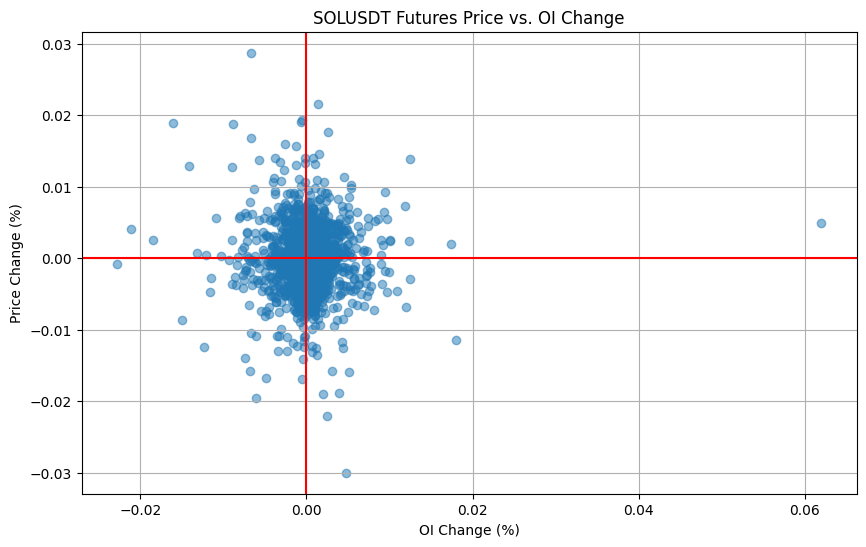

In [33]:
#製作filter動態圖
#filter 的 橫軸是 持倉量變化率，縱軸是價格變化率
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
price_df = pd.read_csv('C:/Quant/studygroup2/SOL_price_change.csv')
OI_df = pd.read_csv('C:/Quant/studygroup2/SOL_OI_longshort_change.csv')

# Merge data
df = pd.merge(price_df, OI_df, left_on='timestamp', right_on='timestamp', suffixes=('_price', '_OI'))
df.set_index('timestamp', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['sum_OI_pct_change'], df['price_pct_change'], alpha=0.5)
plt.xlabel('OI Change (%)')
plt.ylabel('Price Change (%)')
plt.title('SOLUSDT Futures Price vs. OI Change')
plt.axvline(0, color='r', linestyle='-')
plt.axhline(0, color='r', linestyle='-')
plt.grid(True)
plt.show()

### 對long持倉量繪製篩選器

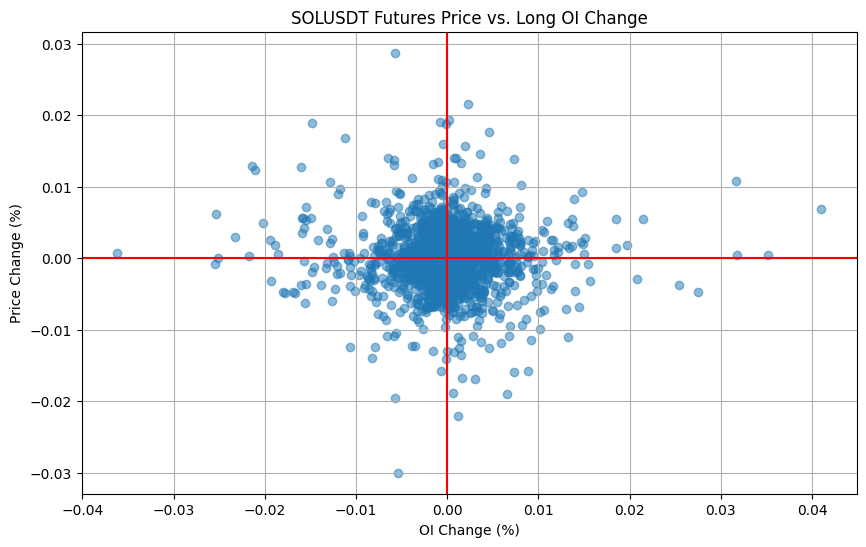

In [35]:
#製作filter動態圖
#filter 的 橫軸是 持倉量變化率，縱軸是價格變化率
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
price_df = pd.read_csv('C:/Quant/studygroup2/SOL_price_change.csv')
OI_df = pd.read_csv('C:/Quant/studygroup2/SOL_OI_longshort_change.csv')

# Merge data
df = pd.merge(price_df, OI_df, left_on='timestamp', right_on='timestamp', suffixes=('_price', '_OI'))
df.set_index('timestamp', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['long_OI_pct_change'], df['price_pct_change'], alpha=0.5)
plt.xlabel('OI Change (%)')
plt.ylabel('Price Change (%)')
plt.title('SOLUSDT Futures Price vs. Long OI Change')
plt.axvline(0, color='r', linestyle='-')
plt.axhline(0, color='r', linestyle='-')
plt.grid(True)
plt.show()

c:\Users\User\anaconda3\envs\quant\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


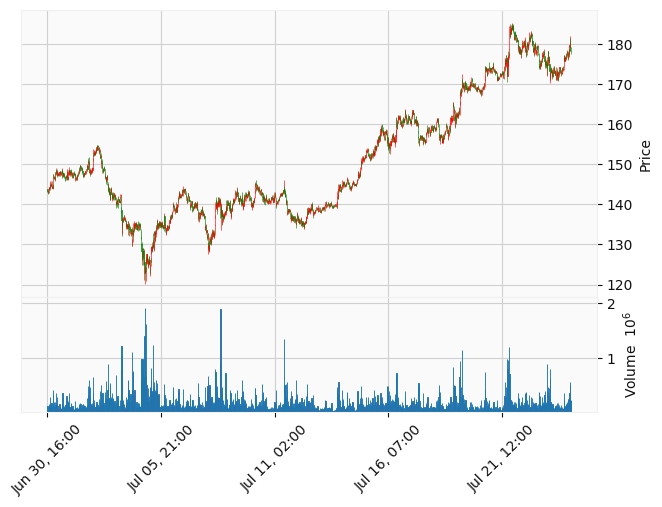

In [36]:
#繪製圖表
plotCandle('C:/Quant/studygroup2/SOL_price.csv')

### 研究反應性

#### 首先我要先取得過熱點的datatime資料

In [37]:
df1 = pd.read_csv('C:/Quant/studygroup2/SOL_price_change.csv')
df2 = pd.read_csv('C:/Quant/studygroup2/SOL_OI_longshort_change.csv')
df3 = pd.merge(df1, df2[['timestamp', 'long_OI_pct_change','sum_OI_pct_change']], on='timestamp', how='left'df3.to_csv('C:/Quant/studygroup2/SOL_stat.csv')

### 在這裡我篩選出過熱點的方法是用標準差

In [60]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_stat.csv')
timestamp_list = []
#針對每一筆資料 我去計算它前面32筆資料的prrice_pct_change跟long_OI_pct_change的平均值跟標準差
#如果現在這筆資料的price_pct_change跟long_OI_pct_change都大於平均值+標準差 就appand這筆資料的timestamp
for i in range(0,len(df)):
    if i >= 32:
        mean_price = df['price_pct_change'][i-32:i].mean()
        std_price = df['price_pct_change'][i-32:i].std()
        mean_OI = df['long_OI_pct_change'][i-32:i].mean()
        std_OI = df['long_OI_pct_change'][i-32:i].std()
        if df['price_pct_change'][i] > mean_price +  1.5*std_price and df['long_OI_pct_change'][i] > mean_OI + 1.5*std_OI:
            timestamp_list.append(df['timestamp'][i])
    

In [61]:
timestamp_list

['2024-07-03 08:15:00',
 '2024-07-04 02:15:00',
 '2024-07-10 13:00:00',
 '2024-07-13 22:30:00',
 '2024-07-20 14:30:00']

### 觀察timestamp_list中所記錄的時間前後各32筆資料的蠟燭圖

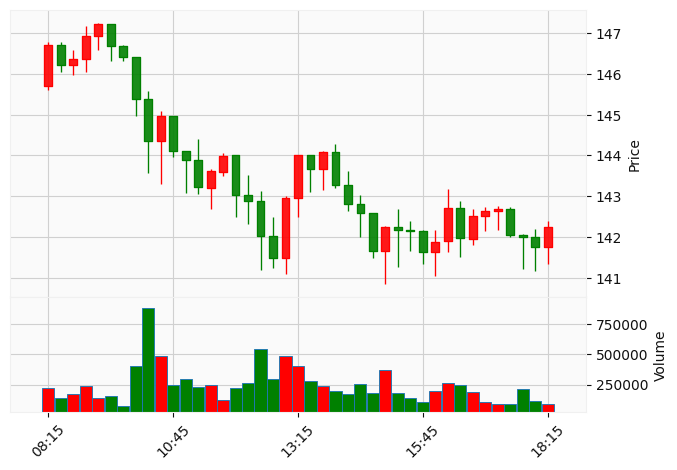

In [45]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-03 08:15:00'
end_time = '2024-07-03 18:15:00'
df = df[start_time:end_time]
ChartCandle(df)

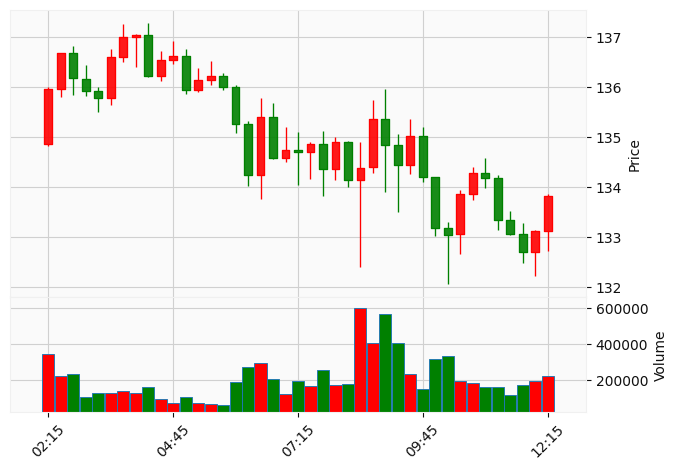

In [46]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-04 02:15:00'
end_time = '2024-07-04 12:15:00'
df = df[start_time:end_time]
ChartCandle(df)

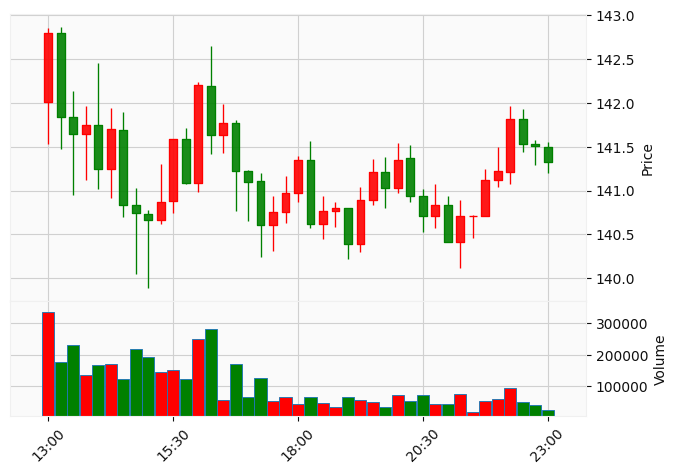

In [54]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-10 13:00:00'
end_time = '2024-07-10 23:00:00'
df = df[start_time:end_time]
ChartCandle(df)

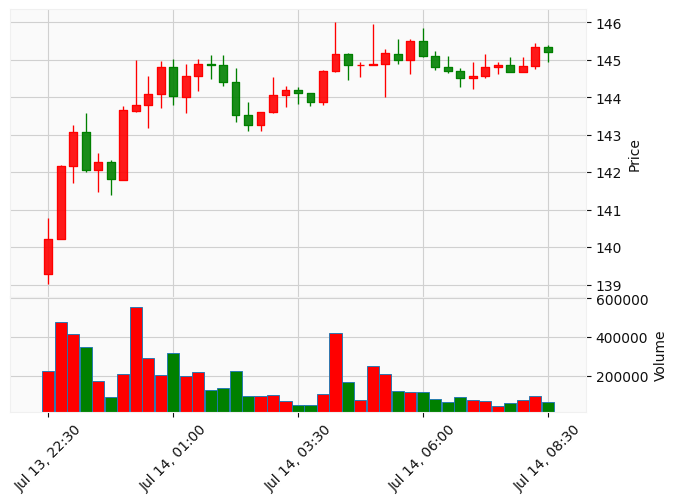

In [55]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-13 22:30:00'
end_time = '2024-07-14 8:30:00'
df = df[start_time:end_time]
ChartCandle(df)

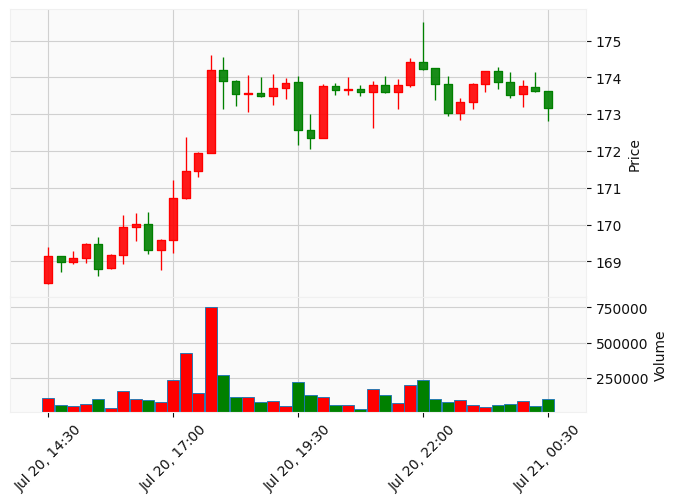

In [57]:
df = pd.read_csv('C:/Quant/studygroup2/SOL_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-20 14:30:00'
end_time = '2024-07-21 00:30:00'
df = df[start_time:end_time]
ChartCandle(df)

#### 從上面的觀察 我們可能還無法看出這個策略是否有顯著的策略

#### 觀察大盤走勢

In [62]:
getcryptoprice('BTCUSDT', datetime(2024, 7, 1), datetime(2024, 7, 25),'15m',15,'C:/Quant/studygroup2/BTC_price.csv')

Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 16:00:00 to 2024-06-30 16:00:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 16:15:00 to 2024-06-30 16:15:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 16:30:00 to 2024-06-30 16:30:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 16:45:00 to 2024-06-30 16:45:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 17:00:00 to 2024-06-30 17:00:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 17:15:00 to 2024-06-30 17:15:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 17:30:00 to 2024-06-30 17:30:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 17:45:00 to 2024-06-30 17:45:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 18:00:00 to 2024-06-30 18:00:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 18:15:00 to 2024-06-30 18:15:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 18:30:00 to 2024-06-30 18:30:00
Symbol: BTCUSDT, Fetched 1 klines from 2024-06-30 18:45:00 to 2024-06-30 18:45:00
Symbol: BTCUSDT,

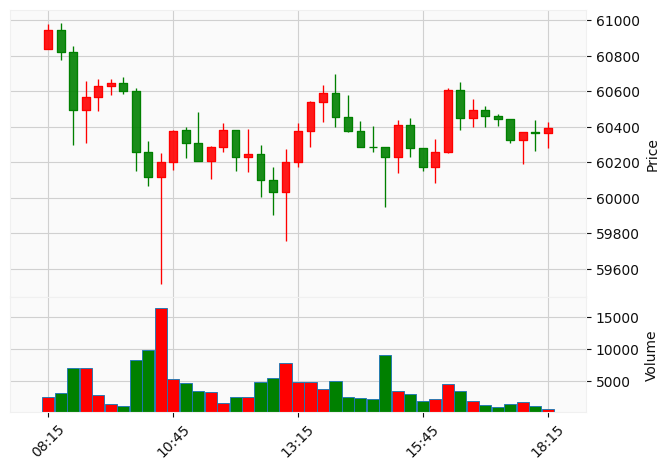

In [67]:
df = pd.read_csv('C:/Quant/studygroup2/BTC_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-03 08:15:00'
end_time = '2024-07-03 18:15:00'
df = df[start_time:end_time]
ChartCandle(df)

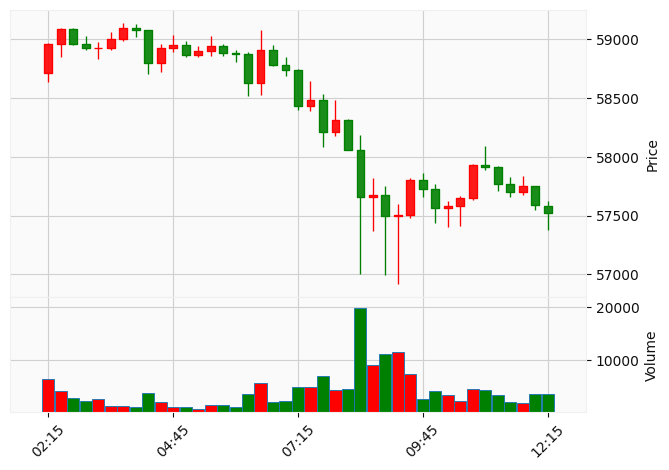

In [68]:
df = pd.read_csv('C:/Quant/studygroup2/BTC_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-04 02:15:00'
end_time = '2024-07-04 12:15:00'
df = df[start_time:end_time]
ChartCandle(df)

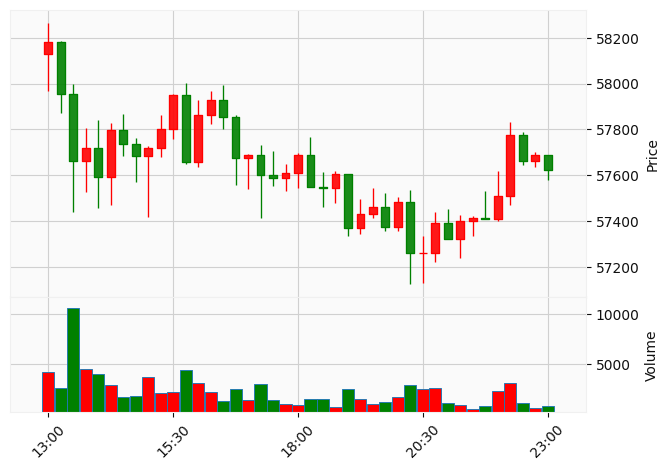

In [69]:
df = pd.read_csv('C:/Quant/studygroup2/BTC_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-10 13:00:00'
end_time = '2024-07-10 23:00:00'
df = df[start_time:end_time]
ChartCandle(df)

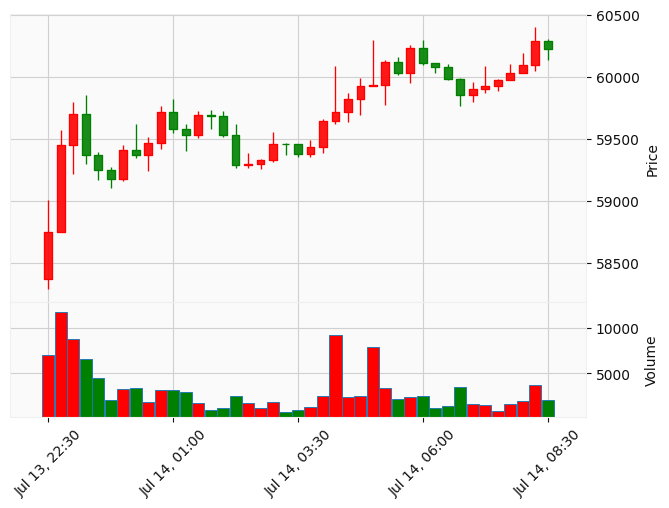

In [70]:
df = pd.read_csv('C:/Quant/studygroup2/BTC_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-13 22:30:00'
end_time = '2024-07-14 8:30:00'
df = df[start_time:end_time]
ChartCandle(df)

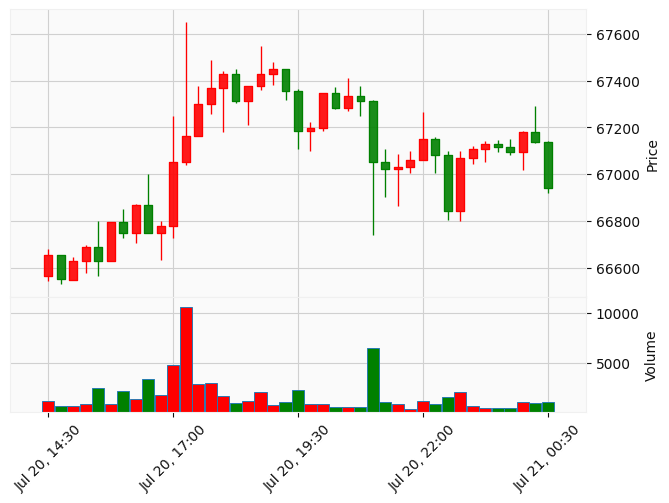

In [71]:
df = pd.read_csv('C:/Quant/studygroup2/BTC_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
start_time = '2024-07-20 14:30:00'
end_time = '2024-07-21 00:30:00'
df = df[start_time:end_time]
ChartCandle(df)

#### 簡單的比較後 我們可以看出確實有異常報酬的存在

#### 在這裡我所用的比特幣預期報酬是用 每15分鐘的空單報酬去推算每15分鐘空單SOL的預期報酬

#### 再來就是看所有過熱點的幾根K棒後事是否有出現異常報酬的現象

In [ ]:
#計算持倉量變化和下兩筆收盤價的相關係數
#幫我用k表示下兩筆 讓我可以調整不同的k值
import pandas as pd
import numpy as np

# Load data
price_df = pd.read_csv('C:/Quant/studygroup2/BTC_price_change.csv')
OI_df = pd.read_csv('C:/Quant/studygroup2/BTC_OI_change.csv')

# Merge data
df = pd.merge(price_df, OI_df, left_on='timestamp', right_on='timestamp', suffixes=('_price', '_OI'))
df.set_index('timestamp', inplace=True)

# Calculate correlation
k = 16
corr = df['OI_pct_change'].corr(df['close'].shift(-k)) #這樣是用現在的OI變化和下兩筆的價格變化做相關係數

# Print correlation
print('Correlation between OI Change and Close Price (Shifted by %d): %.4f' % (k, corr))

#### 這裡我想直接看異常值最高的位置

In [104]:
#計算進場點和其後1天內的股價高點相差的時間
import pandas as pd
import numpy as np

# Load data
price_df = pd.read_csv('C:/Quant/studygroup2/BTC_price_change.csv')
OI_df = pd.read_csv('C:/Quant/studygroup2/BTC_OI_change.csv')

# Merge data
df = pd.merge(price_df, OI_df, left_on='timestamp', right_on='timestamp', suffixes=('_price', '_OI'))
df.set_index('timestamp', inplace=True)

k = 32
# Find entry points
for i in range(k, len(df)):
    entry_points = df['price_pct_change'].iloc[i]> 0 and df['price_pct_change'].iloc[i-k:i].mean() > 0  and df['price_pct_change'].iloc[i-k:i].std() > 0  and df['price_pct_change'].iloc[i] > df['price_pct_change'].iloc[i-k:i].mean() + 1.5 * df['price_pct_change'].iloc[i-k:i].std() and df['OI_pct_change'].iloc[i] > df['OI_pct_change'].iloc[i-k:i].mean() + 1.5 * df['OI_pct_change'].iloc[i-k:i].std()
    if entry_points:
        entry_time = df.index[i]
        print('Entry Time: %s' % entry_time)
        high_price_time = df['close'].iloc[i:i+96].idxmax()
        print('Highest Price Time: %s' % high_price_time)


# Calculate the time difference

# Print time difference
#print('Time Difference between Entry and Highest Price: %s' % time_diff)



Entry Time: 2024-04-30 00:45:00
Highest Price Time: 2024-04-30 00:45:00
Entry Time: 2024-05-02 12:00:00
Highest Price Time: 2024-05-03 03:00:00
Entry Time: 2024-05-03 13:00:00
Highest Price Time: 2024-05-04 10:45:00
Entry Time: 2024-05-12 10:15:00
Highest Price Time: 2024-05-13 09:15:00
Entry Time: 2024-05-19 10:30:00
Highest Price Time: 2024-05-19 10:30:00


## 擬定交易策略

In [77]:
#Strategy
#如果現在的price_pct_change 超過過去32筆資料的price_pct_change的平均值1個標準差
#而且現在的OI_pct_change 也超過去32筆資料的OI_pct_change的平均值1個標準差 就做空
#當price_pct_change已經小於過去32筆資料的price_pct_change的平均值
#或者OI_pct_change已經小於過去32筆資料的OI_pct_change的平均值
#且比開倉價格低，就平倉

#定義交易信號函數
import pandas as pd
import numpy as np

def generate_signals(df):
    k = 32
    p = 8
    price = 0
    flag = 0
    for i in range(32, len(df)):
        if df['price_pct_change'].iloc[i] > 0 and df['price_pct_change'].iloc[i-k:i].mean() > 0 and df['price_pct_change'].iloc[i-k:i].std() > 0 and flag == 0:
            if df['price_pct_change'].iloc[i] > df['price_pct_change'].iloc[i-k:i].mean() + 1 * df['price_pct_change'].iloc[i-k:i].std() and df['long_OI_pct_change'].iloc[i] > df['long_OI_pct_change'].iloc[i-k:i].mean() + 1* df['long_OI_pct_change'].iloc[i-k:i].std():
                df.loc[df.index[i], 'signal'] = -1
                #開倉價格
                price = df['close'].iloc[i]
                print('開倉價格',price)
                flag = 1
        elif df['close'].iloc[i] < price and flag == 1:
            if df['price_pct_change'].iloc[i] < df['price_pct_change'].iloc[i-p:i].mean() - df['price_pct_change'].iloc[i-p:i].std()  or  df['long_OI_pct_change'].iloc[i] < df['long_OI_pct_change'].iloc[i-p:i].mean() - df['long_OI_pct_change'].iloc[i-p:i].std():
                if flag == 1:
                    print('平倉價格',df['close'].iloc[i])
                    df.loc[df.index[i], 'signal'] = 0
                    flag = 0
        else:
            df.loc[df.index[i], 'signal'] = np.nan
    
    #計算signal為-1的次數
    signal_count = df['signal'].value_counts()
    print(signal_count)
    return df


開倉價格 139.417
平倉價格 139.27
開倉價格 140.444
平倉價格 140.11
開倉價格 138.157
平倉價格 135.399
開倉價格 141.657
平倉價格 140.562
開倉價格 145.343
平倉價格 145.265
開倉價格 153.678
平倉價格 153.157
開倉價格 159.323
平倉價格 158.959
signal
-1.0    7
 0.0    7
Name: count, dtype: int64
總績效 0.0877 
交易次數 6 
平均績效 0.0146 
年化報酬率 198.7037 
勝率 1.0 
平均獲利 0.0146 
平均虧損 nan 
賺賠比 nan 
期望值 nan 
最大連續虧損 1
最大資金回落 0.0
夏普比率 575.1865


C:\Users\User\AppData\Local\Temp\ipykernel_26320\2279516769.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade = pd.concat([trade, new_trade], ignore_index=True) #這一步是將新的交易紀錄加入到trade這個dataframe中


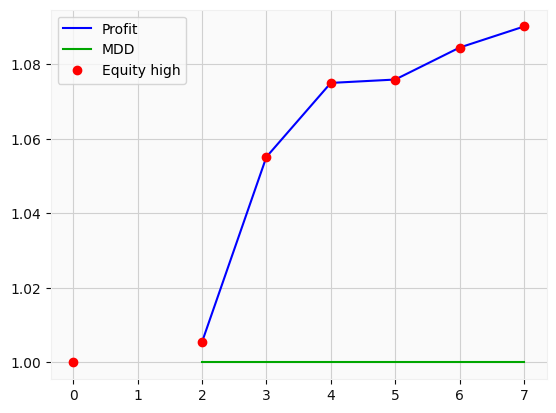

,product,bs,order_time,order_price,cover_time,cover_price,order_unit,ret,acc_ret,acc_max_cap,dd,new_high
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SOLOUSDT,-1,2024-07-08 08:45:00,140.444,2024-07-08 09:00:00,140.110,1,0.005445,1.005445,1.005445,1.0,1.005445
3,SOLOUSDT,-1,2024-07-08 14:30:00,138.157,2024-07-08 16:15:00,135.399,1,0.049407,1.055121,1.055121,1.0,1.055121
4,SOLOUSDT,-1,2024-07-09 23:30:00,141.657,2024-07-10 00:00:00,140.562,1,0.018825,1.074984,1.074984,1.0,1.074984
5,SOLOUSDT,-1,2024-07-14 08:15:00,145.343,2024-07-14 08:45:00,145.265,1,0.000842,1.075889,1.075889,1.0,1.075889
6,SOLOUSDT,-1,2024-07-15 07:00:00,153.678,2024-07-15 07:15:00,153.157,1,0.007976,1.084469,1.084469,1.0,1.084469
7,SOLOUSDT,-1,2024-07-15 23:30:00,159.323,2024-07-16 00:00:00,158.959,1,0.005212,1.090121,1.090121,1.0,1.090121


In [78]:
#實行交易策略
#並且紀律每一次交易的product, bs, order_time, order_price, cover_time, cover_price, order_unit

import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('C:/Quant/studygroup2/SOL_stat.csv')

df.set_index('timestamp', inplace=True)

# Generate signals
signals = generate_signals(df)
signals.dropna(inplace=True)


# Initialize variables
product = 'SOLOUSDT'
trade = pd.DataFrame(columns=['product', 'bs', 'order_time', 'order_price', 'cover_time', 'cover_price', 'order_unit'])
order_unit = 1
order_price = 0
cover_price = 0
bs = 0

# Execute signals
for i in range(len(df)):
    if i == 0:
        continue
    if signals['signal'].iloc[i] == -1 and bs == 0:
        order_price = df['close'].iloc[i]
        order_time = signals.index[i]
        bs = -1
    elif signals['signal'].iloc[i] == 0 and bs == -1:
        cover_price = df['close'].iloc[i]
        cover_time = signals.index[i]
        new_trade = pd.DataFrame([[product, bs, order_time, order_price, cover_time, cover_price, order_unit]],
                                 columns=['product', 'bs', 'order_time', 'order_price', 'cover_time', 'cover_price', 'order_unit'])
        trade = pd.concat([trade, new_trade], ignore_index=True) #這一步是將新的交易紀錄加入到trade這個dataframe中
        bs = 0
# Calculate performance
Performance(trade)